# Sentiment Analysis of Poetry pieces
### *Identifying cluster themes in poetry*

#### Table of Contents

1. Introduction
2. Importing data and packages 
3. Preprocessing
4. Algorithm description
5. Model description
6. Creating a model
<br>
6.1 Hyperparameter tuning
<br>
6.2 Clusters and themes  
7. Predictions
8. Dicussion
9. Executive summary
10. References

_____

#### 1. Introduction

I have been writing poetry since I was 14. My writing has always been free-style and is hard to fit into one theme. I was interested to see how the different pieces would be grouped together - were there underlying, and perhaps unconcious, patterns to my writing?
 
The data I am using is a collection of my poetry pieces, separated into paragrpahs to preserve coherence. There are 50 entries in the data. Most of the pieces contributed approximately 3 paragraphs to the dataset, while some were standalones. However, I often write paragraphs with different themes within the same poem, hence dividing the poems to collect more data does not unnecessary bias the data. 

The sampling process was somewhat biased as I chose the pieces that I was comfortable sharing and didn't have too many personal details. 

------------------------

#### 2 Importing data and packages

of the notebook should contain well-commented code for converting this data to python readable format (and scikit-learn) and loading this data into an appropriate data structure (np.array, pandas dataframe, glob etc.).

In [1]:
#importing basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
#pip install numpy==1.21.4

  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.2
    Uninstalling numpy-1.24.2:
      Successfully uninstalled numpy-1.24.2
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.11.0 requires keras<2.12,>=2.11.0, but you have keras 2.10.0 which is incompatible.
tensorflow-intel 2.11.0 requires tensorboard<2.12,>=2.11, but you have tensorboard 2.10.1 which is incompatible.
tensorflow-intel 2.11.0 requires tensorflow-estimator<2.12,>=2.11.0, but you have tensorflow-estimator 2.10.0 which is incompatible.


In [2]:
#importing sklearn libraries
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


In [4]:
import nltk
#nltk.download('punkt')
import re
import string
import nltk
pd.set_option('display.max_colwidth', 100)

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

In [5]:
# importing the data
df = pd.read_csv('data.txt', sep = '\n', header = None) #the data is separated by new line
df = df.rename(columns = {0:'poetry'}) #renaming the column
df.head()

,poetry
0,Night skies and tales spun from candied sugar - you listened to an entire world I had built in m...
1,"And when I raged at the world, you took every punch without flinching for a single second. I scr..."
2,"We talked about the universe and the stars and the lines on our palms. If there was a forever, I..."
3,Is this what home feels like? Scarred palms and chipped nails. That’s what we were and yet we fi...
4,Starkissed lullabies of fallen heroes and ancient kings. you remind me of the single second as t...


--------------------

#### 3. Preprocessing

should include a markdown section explaining any necessary cleaning, pre-processing, and feature engineering the data requires, and a include a code block completing these steps. You may also wish to perform some basic exploratory data analysis at this point reporting and visualizing some samples and appropriate descriptive statistics.

The data processing pipeline is divided into 2 primary sections:
1. **Converting text into vectorized matrix**

- I first clean the data by removing unnecessary characters, like special characters, multiple space characters, or optionally, stop words. This reduces the size of the matrix and makes it easier to work with. 

- I then vectorize the data using TF-IDF. This is a common method of vectorizing text data. It is a combination of two methods: Term Frequency and Inverse Document Frequency. 
	- Term Frequency is the number of times a word appears in a document.
	- Inverse Document Frequency is the inverse of the number of documents that contain the word.
	- TF-IDF is the product of the two. It is a measure of how important a word is to a document in a collection of documents.

After processing the data, my X variable is *<50x30 sparse matrix of type '<class 'numpy.float64'>'*, a 50x30 matrix.

2. **Reducing the dimensionality of the matrix**
While the matrix allows me to run a model, it has lot of dimensions. I reduce the dimensionality of the matrix using PCA (Principal Component Analysis), so I can visualize the data. PCA is discussed in detail in the Discussion section. 

In [6]:
stopwords.words('english')

def clean_data(text:str, remove_stopwords: bool = True) -> str:
    """
    Preprocesses a given string of text by removing special characters, multiple space characters, and optionally, stopwords.

    Args:
        text (str): A string of text to be preprocessed.
        remove_stopwords (bool, optional): A boolean value indicating whether or not to remove stopwords from the text. Defaults to True.

    Returns:
        str: The preprocessed string of text.

    Example:
        >>> preprocess("This is an example sentence! It includes special characters, such as @ and $.", True)
        'example sentence includes special characters'
    """
    #remove special characters
    text = re.sub("[^A-Za-z]+", " ", text)
    
    #remove multiple space characters
    text = re.sub("\s+"," ", text)

    #remove stopwords
    if remove_stopwords == True:
        #tokenizing
        tokens = word_tokenize(text)
        #check for stopwords
        tokens = [word for word in tokens if not word.lower() in stopwords.words("english")]
        text = " ".join(tokens)

    text = text.lower()
    return text

clean_data(df['poetry'][0], True)


'night skies tales spun candied sugar listened entire world built head laughed cue smiled position love never felt like breath fresh air friendship never tasted like freedom'

In [7]:
 #using the tfidf vectorizer to convert the text into a matrix of token counts

def vectorize(df):
    """
    Vectorizes and scales the given text data using the TfidfVectorizer.

    Args:
        df (pd.Series): A pandas Series of text data.

    Returns:
        X (np.array): A numpy array of the vectorized text data.
        vec (TfidfVectorizer): The fitted TfidfVectorizer object.
    """
    vec = TfidfVectorizer(sublinear_tf=True, analyzer='word', norm='l2', min_df=5, max_df=0.95) 
    X_vec = vec.fit_transform(df) #fitting and transforming the data

    scaler = StandardScaler(with_mean = False) #scaling the data
    X_fit = scaler.fit(X_vec) 
    X = scaler.transform(X_vec)

    return (X, vec)


In [14]:
df['cleaned'] = df['poetry'].apply(lambda x: clean_data(x, remove_stopwords=True))
X, vec = vectorize(df['cleaned'])
X.shape

(53, 33)

--------

#### 4. Algorithm description 

Since my data is text, I will be using a clustering algorithm, which is an unsupervised learning method. Clustering is an undirected task, meaning that there is no target variable, and is used to identify underlying patterns in the data. The task here is to group the data into clusters based on the similarity of the data points. 

In clustering algorithms, the number of clusters is not known beforehand. The algorithm will either try to find the optimal number of clusters based on the data, or we can hypertune this parameter. Since there is no target variable, we cannot use the accuracy metric to evaluate the model. Instead, we can use the silhouette score, which is a measure of how similar the data points are within a cluster, and how dissimilar they are from other clusters. Therefore, my data is not split into training and test sets.

----------

#### 5. Model description

**Kmeans clustering**

The model I am using is Kmeans clustering. Kmeans is an iterative algorithm that tries to find the optimal number of clusters in the data. It does this by assigning each data point to a cluster, and then calculating the centroid of each cluster. The centroid is the mean of all the data points in the cluster. 

The algorithm is as follows:

1. Initialize the centroids by randomly selecting k data points from the dataset.
2. Assign each data point to the closest centroid. The closest centroid is the one with the smallest Euclidean distance.
3. Calculate the new centroids by taking the mean of the assigned data points.
4. Repeat steps 2 and 3 until the centroids do not change.

The algorithm is guaranteed to converge, but it may not converge to the global minimum. This is why we need to run the algorithm multiple times with different initial centroids and choose the one with the lowest loss.

The number of clusters is a hyperparameter that can be tuned. The optimal number of clusters is the one that minimizes the sum of squared distances between the data points and their assigned cluster centroids. This is called the within-cluster sum of squares (WCSS). The WCSS is the loss function that we are trying to minimize.

The loss function is defined as:

$ \sum_{i=1}^{n} \sum_{j=1}^{k} r_{ij} ||x_i - \mu_j||^2 $

- where $r_{ij}$ is 1 if data point $x_i$ is assigned to cluster $j$, and 0 otherwise. 
- $n$ is the number of data points.
- $k$ is the number of clusters.
- $x_i$ is the data point.
- $\mu_j$ is the centroid of cluster $j$.
- $||x_i - \mu_j||^2$ is the squared Euclidean distance between the data point and the centroid.


-------------

#### 6. Creating a model

In [15]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=35)

X_train, X_test = train_test_split(X, test_size=0.1, random_state=35)
X_train.shape, X_test.shape

((47, 33), (6, 33))

In [16]:
def kmeans_model(X: np.ndarray, n: int) -> tuple:
    """
    Creates a KMeans model with the given number of clusters and fits it to the input data. 
    Calculates the silhouette score of the resulting clusters and returns the cluster labels 
    and the silhouette score as a tuple.

    Parameters:
        X (np.ndarray): A 2D array of shape (n_samples, n_features) containing the input data to cluster.
        n (int): The number of clusters to use in the KMeans model.

    Returns:
        tuple: A tuple of (clusters, score), where clusters is a 1D array of length n_samples 
        containing the cluster labels for each sample in X, and score is the silhouette score 
        for the resulting clustering.

    """
    # create and fit KMeans model
    kmeans = KMeans(n_clusters=n, random_state=35)
    kmeans.fit(X)
    
    # get cluster labels and silhouette score
    clusters = kmeans.labels_
    score = silhouette_score(X, clusters)
    
    return (clusters, score)


**Silhouette score**

The Silhouette score is a measure of how well the data points have been clustered. It is calculated for each data point and is between -1 and 1. A score of 1 means that the data point is very similar to other data points in the cluster, and dissimilar to data points in other clusters. A score of -1 means that the data point is not similar to other data points in the cluster, and is very similar to data points in other clusters. A score of 0 means that the data point is on or very close to the decision boundary between two clusters.

The Silhouette score is calculated as follows:

$ s_i = \frac{b_i - a_i}{max(a_i, b_i)} $

- $a_i$ is the mean distance between the data point and all other data points in the same cluster.
- $b_i$ is the mean distance between the data point and all other data points in the nearest cluster.
- $s_i$ is the Silhouette score for the data point.



In [17]:
example_model = kmeans_model(X_train, n=3)
clusters = example_model[0]
print(f'The Silhouette score for a K means model with 3 clusters is {example_model[1]:.4}')

The Silhouette score for a K means model with 3 clusters is 0.06592


In [25]:
X

<47x33 sparse matrix of type '<class 'numpy.float64'>'
	with 217 stored elements in Compressed Sparse Row format>

##### 6.1. Hyperparameter tuning

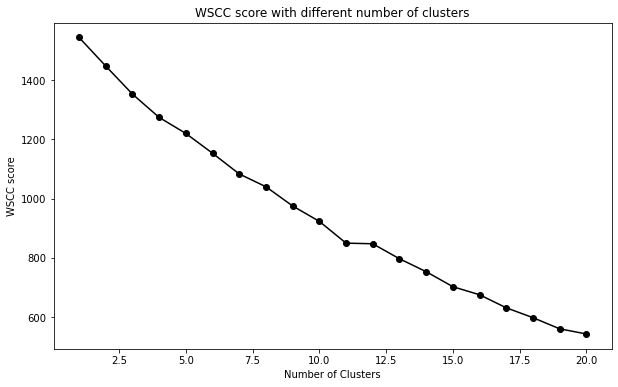

In [18]:
wcss = []
cluster = np.arange(1, 21)
for i in cluster:
    kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state=35)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

plt.figure(figsize = (10, 6))
plt.plot(cluster, wcss, color = 'black', marker = 'o')
plt.xlabel('Number of Clusters')
plt.ylabel('WSCC score')
plt.title('WSCC score with different number of clusters')
plt.show()

The WCSS is a function of the number of clusters. The optimal number of clusters is the one that minimizes the WCSS. However, the WCSS is not a smooth function, and it is difficult to find the global minimum. Therefore, we can use the elbow method to find the optimal number of clusters. The elbow method is a heuristic method that plots the WCSS against the number of clusters, and the optimal number of clusters is the one where the WCSS starts to flatten out.

In the above plot, we do not see this happening. The WSCC decreases without flattenig out. This is either because the data is not well clustered or because there isn't enough data. This also means that we cannot use the WCSS score to find the optimal number of clusters because it shows a tendency to overfit the data. It will naturally show the lowest score for the highest possible clusters, i.e., the number of data points. 

Instead, we can analyze the silhouette score and cluster themes to see if adding a new cluster makes sense. If there are no new themes, then we can stop adding clusters.

##### 6.2 Clusters and themes

In [22]:
n = [3, 4, 5]
models = {}

for i in n:
    models[i] = kmeans_model(X_train, i)

models

{3: (array([1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 2, 1, 1, 0, 2, 1, 2, 0, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1,
         1, 1, 1]),
  0.06591604594407732),
 4: (array([0, 2, 2, 0, 2, 0, 3, 2, 1, 3, 1, 1, 0, 2, 3, 1, 2, 1, 3, 0, 0, 2,
         2, 2, 0, 1, 2, 0, 3, 1, 0, 0, 2, 1, 0, 0, 0, 2, 0, 0, 2, 1, 2, 0,
         0, 0, 2]),
  0.05945433087415224),
 5: (array([1, 3, 4, 1, 3, 2, 1, 4, 4, 0, 3, 3, 1, 3, 0, 2, 1, 3, 0, 1, 1, 3,
         1, 4, 4, 3, 3, 1, 0, 4, 4, 4, 1, 2, 1, 1, 1, 1, 1, 1, 4, 3, 4, 1,
         1, 1, 4]),
  0.05914395263168747)}

In [23]:
def get_top_keywords(clusters, n_terms):
    """
    Get the top keywords for each cluster based on the mean TF-IDF scores.

    Args:
    - n_terms (int): The number of top keywords to return for each cluster.

    Returns:
    - None: This function does not return a value, but it prints the top keywords for each cluster.
    """
    # Get the mean TF-IDF scores for each cluster
    df_train = pd.DataFrame(X_train.todense()).groupby(clusters).mean()

    # Get the feature names for the TF-IDF matrix
    terms = vec.get_feature_names()

    # Print the top keywords for each cluster
    for i, r in df_train.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]]))


In [24]:
for key, value in models.items():
    print(f'For {key} clusters')
    cluster = value[0]
    get_top_keywords(cluster, 10)
    print('----------------------------------------')

For 3 clusters

Cluster 0
across,tell,sky,world,light,sun,love,eyes,way,beauty

Cluster 1
home,become,know,bones,never,feel,hands,everything,like,every

Cluster 2
someone,back,like,time,love,world,never,ever,universe,skies
----------------------------------------
For 4 clusters

Cluster 0
much,everything,every,become,world,home,time,many,like,feel

Cluster 1
heart,everything,every,world,like,universe,never,ever,love,skies

Cluster 2
sky,heart,one,never,war,across,tell,every,hands,bones

Cluster 3
across,tell,sky,world,light,sun,love,eyes,way,beauty
----------------------------------------
For 5 clusters

Cluster 0
time,across,light,tell,sky,way,sun,love,eyes,beauty

Cluster 1
sun,much,everything,like,know,many,world,become,every,feel

Cluster 2
feel,feels,hands,heart,everything,back,ever,time,skies,universe

Cluster 3
ever,world,everything,like,bones,war,tell,one,love,never

Cluster 4
every,sky,war,home,eyes,across,hands,like,heart,feels
----------------------------------------


After analyzing the clusters, I found that the optimal number of clusters is 3. After 3 clusters, themes start to repeat. To label them better, I will look at more keywords in them. 

In [25]:
model = KMeans(n_clusters=3, random_state=35)
model.fit(X_train)
clusters = model.labels_
get_top_keywords(clusters, 20)


Cluster 0
become,war,back,every,feel,know,inside,time,hands,ever,across,tell,sky,world,light,sun,love,eyes,way,beauty

Cluster 1
one,time,sky,many,across,world,tell,heart,war,feels,home,become,know,bones,never,feel,hands,everything,like,every

Cluster 2
feels,beauty,become,hands,bones,everything,eyes,feel,every,tell,someone,back,like,time,love,world,never,ever,universe,skies


After looking at the keywords in each cluster, I found that the clusters are as follows:

- Cluster 0 - *Elemental*: this cluster contains words related to the elements like sky and making comparisons of different aspects of life to abstract elemenets. 
- Cluster 1 - *Solitude*: this cluster contains words related to loneliness and what the process of feeling alone feels 
- Cluster 2 - *Intimacy*: this cluster contains words related to love and relationships and has a general positive tone. 


In [26]:
df_train['cluster'] = clusters 
cluster_map = {0: "Elemental", 1: "Solitude", 2: "Intimacy"}
# apply mapping
df_train['cluster'] = df_train['cluster'].map(cluster_map)
df_train.head()

<ipython-input-26-01c4f1f7b5a1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['cluster'] = clusters
<ipython-input-26-01c4f1f7b5a1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['cluster'] = df_train['cluster'].map(cluster_map)


,poetry,cleaned,cluster
48,Knowledge is poisonous for those who do not know how to handle it. Not everyone knows how to swi...,knowledge poisonous know handle everyone knows swing double edged blade hold fragility ticking t...,Solitude
32,To the boy who never broke Only bent into jagged pieces one by one. You have stood with tremblin...,boy never broke bent jagged pieces one one stood trembling rage long long limbed fingers sharp e...,Solitude
20,But it feels like the slow burning of jumping into a frozen lake instead. It is ice and frost an...,feels like slow burning jumping frozen lake instead ice frost winter nights brutal sky bed snow ...,Solitude
51,There are empty corridors where the first rays of sunlight flitter through like muffled laughter...,empty corridors first rays sunlight flitter like muffled laughter shy glances promised battlefie...,Solitude
38,"Tell me how your hands beg to touch cold waters, and soft palms and the rightness of a lover bes...",tell hands beg touch cold waters soft palms rightness lover beside every one bones hand aches lo...,Solitude


#### 7. Predictions

Since I am using an unsupervised learning method, I cannot make predictions. Instead, I can use the model to cluster new data points. I will give my model a new string of text and see which cluster it belongs to.

In [27]:
test_clusters = model.predict(X_test)

df_test['cluster'] = test_clusters
df_test['cluster'] = df_test['cluster'].map(cluster_map)
df_test

<ipython-input-27-b2c277e9c232>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['cluster'] = test_clusters
<ipython-input-27-b2c277e9c232>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['cluster'] = df_test['cluster'].map(cluster_map)


,poetry,cleaned,cluster
7,The callouses of your hands get stuck in their wounds. Only to brush past them when the skin hea...,callouses hands get stuck wounds brush past skin heals justice blade carves rock solace fire tem...,Solitude
43,You are a genius With scattered pieces of paper under your pillow Your mind is a cosmic explosio...,genius scattered pieces paper pillow mind cosmic explosion stars among glowing gases much darkne...,Solitude
41,You are Atlas Holding the weight of all the voices inside your head Sometimes the thoughts get t...,atlas holding weight voices inside head sometimes thoughts get much knees buckle think letting s...,Solitude
23,"Tell me, if my bones turn into starlight one day, would your soul ever forget the way my eyes bu...",tell bones turn starlight one day would soul ever forget way eyes burn like dragon fire sun way ...,Elemental
14,"Loving someone feels like home, like a pair of warm arms wrapped around you in an embrace filled...",loving someone feels like home like pair warm arms wrapped around embrace filled sunshine cherry...,Solitude
34,To the boy with smiles like the dying sun. Where have you learned such defeat? You charge head f...,boy smiles like dying sun learned defeat charge head first battles bleeding blind learned desper...,Solitude


The model predicts 5 out of 6 inputs correctly, just from my own judgement of what the poetry themes were. However, the training data is very small and has a lot of data points in the second cluster *Solitude* so the correctly labelled points could just be because the model is biased. 

#### 8. Dicussion

My training data is currently a 47x33 sparse matrix. I will reduce the dimensionality of the data using PCA. I will reduce the number of components to 2 so that I can visualize the data.

In [38]:
X_train.shape

(47, 33)


**Principal Component Analysis (PCA)**

PCA is a dimensionality reduction technique that is used to reduce the number of features in the data. It is a linear transformation method that tries to find the directions of maximum variance in high-dimensional data and projects it onto a new subspace with equal or fewer dimensions than the original one.

The algorithm is as follows:

1. Standardize the data.
2. Calculate the covariance matrix of the standardized data.
3. Calculate the eigenvectors and eigenvalues of the covariance matrix.
4. Sort the eigenvalues in descending order and choose the top k eigenvectors.
5. Construct a projection matrix from the selected k eigenvectors.
6. Transform the data onto the new subspace using the projection matrix.

PCA is a linear transformation method, so it is sensitive to outliers. Therefore, it is important to standardize the data before applying PCA. That is why I standardized the data in my preprocessing step.


In [39]:
def vector_reduction(df, X):
    # initialize PCA with 2 components
    pca = PCA(n_components=2, random_state=35)
    # pass our X to the pca and store the reduced vectors into pca_vecs
    pca_vecs = pca.fit_transform(X.toarray())
    # save our two dimensions into x0 and x1
    x0 = pca_vecs[:, 0]
    x1 = pca_vecs[:, 1]
    df['x0'] = x0
    df['x1'] = x1
    return df

In [40]:
df = vector_reduction(df_train, X_train)
df.head()

,poetry,cleaned,cluster,x0,x1
48,Knowledge is poisonous for those who do not know how to handle it. Not everyone knows how to swi...,knowledge poisonous know handle everyone knows swing double edged blade hold fragility ticking t...,Solitude,-0.518962,1.914261
32,To the boy who never broke Only bent into jagged pieces one by one. You have stood with tremblin...,boy never broke bent jagged pieces one one stood trembling rage long long limbed fingers sharp e...,Solitude,-1.517533,0.330445
20,But it feels like the slow burning of jumping into a frozen lake instead. It is ice and frost an...,feels like slow burning jumping frozen lake instead ice frost winter nights brutal sky bed snow ...,Solitude,-0.385720,-2.860270
51,There are empty corridors where the first rays of sunlight flitter through like muffled laughter...,empty corridors first rays sunlight flitter like muffled laughter shy glances promised battlefie...,Solitude,0.888906,-0.868095
38,"Tell me how your hands beg to touch cold waters, and soft palms and the rightness of a lover bes...",tell hands beg touch cold waters soft palms rightness lover beside every one bones hand aches lo...,Solitude,-2.134565,-0.016375


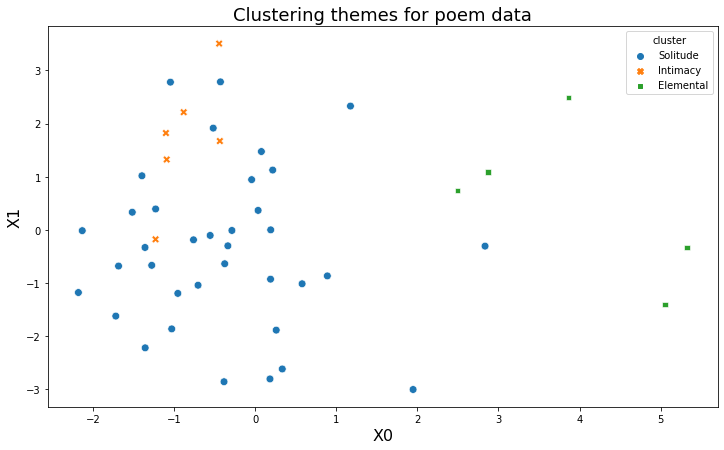

In [41]:
plt.figure(figsize=(12, 7))
# set a title
plt.title("Clustering themes for poem data", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df_train, x='x0', y='x1', hue='cluster', s=60, style ='cluster')
plt.show()

The above plot shows the data points in the new 2D subspace. Each color represents a different cluster. The data points are not very distinct, and there is a lot of overlap between the clusters. We can also see many data points in the cluster *Solitude* and the most overlap can be seen between the clusters *Solitude* and *Intimacy*. Which makes sense from the perspective of the data. It is difficult to differentiate between emotions and many of the words I use for poems relating to 'Solitude' can also be used for poems relating to 'Intimacy'.

The model might be performing poorly because of lack of data, or due to the vectorizer. The vectorizer only looks at the frequency of the words in the document, and not the context. Therefore, it is not able to capture the nuances of the words.

------------

#### 9. Executive summary

The data pipeline for this project has four distinct steps: 
1. the text data is first processed and cleaned. It had to be vectorized so that it could be used in the model. For this I used the TF-IDF vectorizer.
2. The data is then clustered using the K-Means algorithm. The optimal number of clusters is found using the cluster themes and the Silhouette score.
3. The model is then used to cluster new data points.
4. The data is then reduced in dimensionality using PCA so it can be visualized and analyzed.

On closer inspection of the model, I found that it is biased and makes faulty predictions at times. I identified the small sample size and the vectorization method as the key limitations for this. As the sample size cannot be changed, I looked into the latter. After further research on the limitation of TF-IDF I found that word embedding methods like Word2Vec and GloVe are better suited for this task.

![Alt text](data%20pipeline.jpg)



------------------

#### Extension

**Important note**

Word2Vec does not work with the old version of numpy, therefore I had to upgrade it. However, if you run the next code cell, the new version of numpy will not be compatible with the previous code. 

In [16]:
!pip install numpy==1.24.2


In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import gensim

In [3]:
df = pd.read_csv('data.txt', sep = '\n', header = None) #the data is separated by new line
df = df.rename(columns = {0:'poetry'}) #renaming the column
#df['cleaned'] = df['poetry'].apply(lambda x: clean_data(x, remove_stopwords=True))


In [6]:
gensim.utils.simple_preprocess(df['poetry'][0])
df['cleaned'] = df['poetry'].apply(lambda x: gensim.utils.simple_preprocess(x))
X_train, X_test = train_test_split(df['cleaned'], test_size = 0.1)

In [10]:
w2v_model=gensim.models.Word2Vec(X_train, window=5, min_count=2, vector_size=100)
w2v_model.wv.index_to_key
w2v_model.wv.most_similar("sky", topn=2)


[('and', 0.5089738368988037), ('that', 0.4910193085670471)]

In [11]:
words = set(w2v_model.wv.index_to_key )

X_train_vect = []
for ls in X_train:
    temp = []
    for i in ls:
        if i in words:
            temp.append(w2v_model.wv[i])
    X_train_vect.append(temp)

In [12]:
X_train_vect_avg = []
for v in X_train_vect:
    v = np.array(v)
    if v.size:
        X_train_vect_avg.append(v.mean(axis=0))
    else:
        X_train_vect_avg.append(np.zeros(100, dtype=float))
        

In [15]:
X_train_vect_avg = np.asmatrix(X_train_vect_avg)
kmeans = KMeans(n_clusters=3, random_state=30)
kmeans.fit(X_train_vect_avg)
clusters = kmeans.labels_
silhouette_score(X_train_vect_avg, clusters)


0.119951196

After vectorizing the data using Word2Vec, the model performs slightly better. The Silhouette score went from approximately 0.065 to 0.12. NLP is a large and rapidly expanding field and new methods are being introduced every few months. Models like ELMo could further improve the model. However, there is an extent to which the model can be improved by using a different vectorization method because the size of the data is still very small.

#### 10. References

D'Agostino. R. (2021) *Text Clustering with TF-IDF in Python* Medium https://medium.com/mlearning-ai/text-clustering-with-tf-idf-in-python-c94cd26a31e7

Kumaratunga. S. (2020) *KMeans Hyper-parameters Explained with Examples* Medium https://towardsdatascience.com/kmeans-hyper-parameters-explained-with-examples-c93505820cd3

Sharma. R. (2022) *What is Clustering and Different Types of Clustering Methods* upGrad https://www.upgrad.com/blog/clustering-and-types-of-clustering-methods/#:~:text=There%20are%20two%20different%20types,clustering%20technique%20is%20K%2Dmeans.

Ganesan. K., (n.d.) *How to Use Tfidftransformer & Tfidfvectorizer?* Kavita Ganesan https://kavita-ganesan.com/tfidftransformer-tfidfvectorizer-usage-differences/#.Y_C6bXZBy5f

Valeti D., (2021) *Classification using Word2vec* Medium https://medium.com/@dilip.voleti/classification-using-word2vec-b1d79d375381
